# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [3]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.93030846                                          
ERROR                                               
0.0032105404317541732                               
SCORE:                                                               
0.9370764800000002                                                   
ERROR                                                                
0.0024428951008617535                                                
SCORE:                                                                        
0.8553223799999999                                                            
ERROR                                                                         
0.013509800928361935                                                          
SCORE:                                                                        
0.9119639399999999                                                            
ERROR                             

SCORE:                                                                         
0.9372911400000001                                                             
ERROR                                                                          
0.002437331098987682                                                           
SCORE:                                                                         
0.9366116200000001                                                             
ERROR                                                                          
0.0022002063293593806                                                          
SCORE:                                                                         
0.9305171399999999                                                             
ERROR                                                                          
0.0023075157199616437                                                          
SCORE:                                  

In [6]:
best

{'x_learning_rate': 0.16159424030448688,
 'x_max_depth': 16,
 'x_min_child': 8.0,
 'x_pos_weight': 15.85087174258454,
 'x_subsample': 0.8871786307932479,
 'x_tree_colsample': 0.8839869651229835}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [7]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.94864+0.00075	test-auc:0.91939+0.00168
[1]	train-auc:0.96152+0.00273	test-auc:0.92730+0.00360
[2]	train-auc:0.96890+0.00101	test-auc:0.93272+0.00279
[3]	train-auc:0.97229+0.00083	test-auc:0.93609+0.00255
[4]	train-auc:0.97435+0.00075	test-auc:0.93765+0.00206
[5]	train-auc:0.97632+0.00062	test-auc:0.93900+0.00187
[6]	train-auc:0.97839+0.00063	test-auc:0.94053+0.00192
[7]	train-auc:0.97981+0.00055	test-auc:0.94114+0.00159
[8]	train-auc:0.98139+0.00074	test-auc:0.94231+0.00180
[9]	train-auc:0.98281+0.00046	test-auc:0.94325+0.00161


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8839869651229835, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.16159424030448688, max_delta_step=0, max_depth=16,
              min_child_weight=8.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=15.85087174258454,
              subsample=0.8871786307932479, tree_method=None,
              validate_parameters=False, verbosity=None)

In [8]:
model.save_model(datapath+'../spock/models/spock.json')

In [11]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock.json')

# SPOCK

Text(0.5, 1.0, 'ROC curve (AUC = 0.955)')

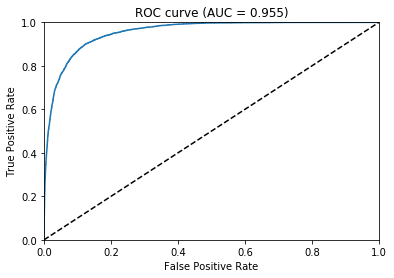

In [12]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [13]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9999192953109741, TPR = 0.0, FPR = 0.0
Threshold 0.9993033409118652, TPR = 0.03965256797583082, FPR = 5.742835812324125e-05
Threshold 0.9987364411354065, TPR = 0.07949395770392749, FPR = 0.000229713432492965
Threshold 0.9985067248344421, TPR = 0.09459969788519637, FPR = 0.0005742835812324125
Threshold 0.9979015588760376, TPR = 0.12953172205438065, FPR = 0.0008614253718486188
Threshold 0.9972278475761414, TPR = 0.1614425981873112, FPR = 0.0012059955205880664
Threshold 0.9966657757759094, TPR = 0.18731117824773413, FPR = 0.0014357089530810314
Threshold 0.9958083629608154, TPR = 0.21676737160120846, FPR = 0.00183770745994372
Threshold 0.9949290752410889, TPR = 0.24339123867069487, FPR = 0.0023545626830528913
Threshold 0.99436354637146, TPR = 0.26076283987915405, FPR = 0.0027565611899155805
Threshold 0.9937962293624878, TPR = 0.2794561933534743, FPR = 0.0031011313386550277
Threshold 0.9935228824615479, TPR = 0.286631419939577, FPR = 0.0034457014873944753
Threshold 0.99304366111

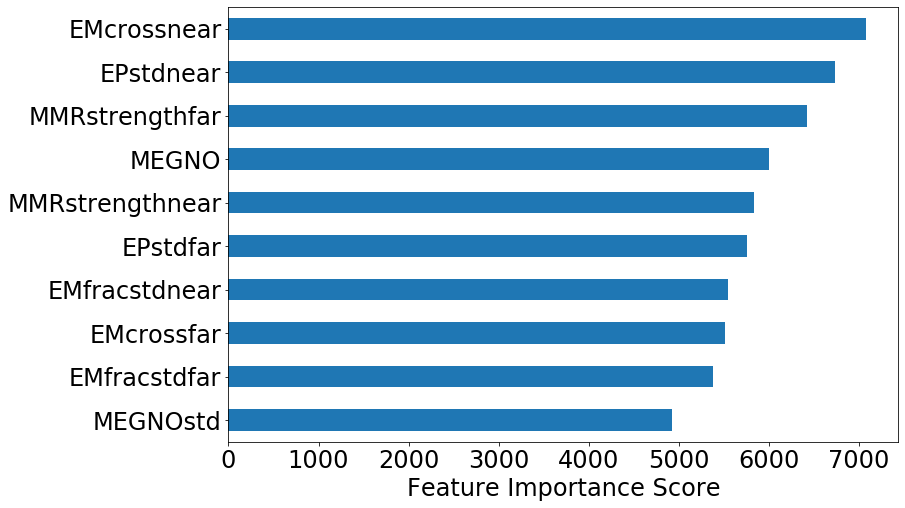

In [14]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0, 2550.9)

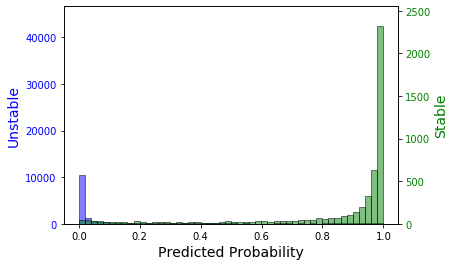

In [15]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

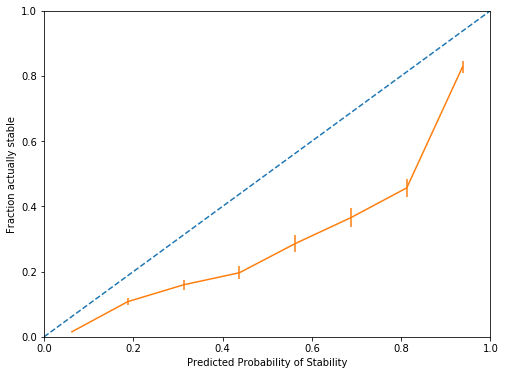

In [16]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

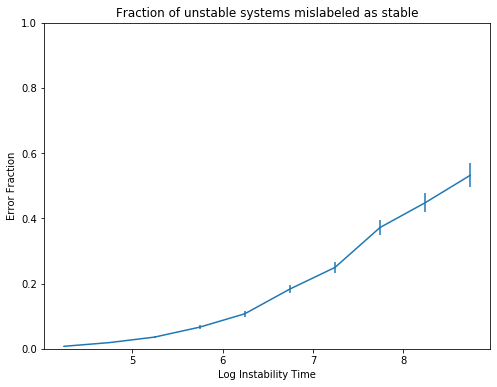

In [17]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')